## Project Title: Hand Gesture Recognition

This project will consist of two parts. In Part A, a small sample of hand gestures in American Sign Language (ASL) will be collected to be used in Part B of this project. In Part B I will train a convolutional neural network (CNN) to make classifications on different hand gestures. 


## Part A. Data Collection


### Reference: American Sign Language 

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing.

The hand gestures representing English alphabet are shown below. This project focuses on classifying a subset of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, I want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)


### Generating Data
I will produce the images required for the test set of this Project. I will take three images of the Americal Sign Language gestures for letters A - I (total of 27 images).

The following are a guide on how to better perfrom the data collection steps:

1. Familiarize yourself with American Sign Language gestures for letters from A - I (9 letters).
2. Take three pictures at slightly different orientation for each letter gesture using your
mobile phone.
 - Ensure adequate lighting while you are capturing the images.
 - Use a white wall as your background.
 - Use your right hand to create gestures (for consistency).
 - Keep your right hand fairly apart from your body and any other obstructions.
 - Avoid having shadows on parts of your hand.
3. Transfer the images to your laptop for cleaning.

### Cleaning Data
To simplify the machine learning the task, I will standardize the training images. I will make sure that all of my images are of the same size (224 x 224 pixels RGB), and have the hand in the center of the cropped regions.

## Part B. Building a CNN Model

### Part 1. Data Loading and Splitting

In [ ]:
# Mounting my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import Relevant Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F

import time

In [ ]:
# defining the data directory
data_dir = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Hand_Gesture_Dataset"

# Transforming the Images to Tensors
    ## Since the images are already cropped for size of 224 x 224, I will just convert the image to Tensors and normalized range [-1, 1]
data_transform = transforms.Compose([transforms.Resize([int(224), int(224)]),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# loading and transforming the data using ImageFolder
data = datasets.ImageFolder(data_dir, transform=data_transform)

In [ ]:
# printing the Number of images in the dataset
print('The Total Number of Images in the Dataset is:', len(data))

The Total Number of Images in the Dataset is: 2431


In [ ]:
### getting the relevant indices for the train, validation, and test sets
  
indices_train = []
indices_Validation = []
indices_test = []

for i in range(len(data)): 

  # Finding the Student Number for Each hand gesture image
  Student_Number = int((data.imgs[i][0]).split('/')[-1].split("_")[0])

  # All stdundets with the student number less than and equal to 72, will be grouped into the training dataset
  # All stdundets with the student number between 72 and 92 (including 92), will be grouped into the validation dataset
  # All other stdundets will be grouped into the test dataset
  indices_train.append(i) if Student_Number <= 72 else (indices_Validation.append(i) if Student_Number > 72 and Student_Number <= 92 else indices_test.append(i))

  # This grouping arrangment, splits the data into approximately 70% Train data, 20% validation data, and 10% Testing data

# Printing the % of the Train, Validation, and Test Datasets
print('The % of the Train Samples are: {0:.{1}f}%'.format(len(indices_train)/len(data)*100,2))
print('The % of the Validation Samples are: {0:.{1}f}%'.format(len(indices_Validation)/len(data)*100,2))
print('The % of the Test Samples are: {0:.{1}f}%'.format(len(indices_test)/len(data)*100,2))


The % of the Train Samples are: 69.44%
The % of the Validation Samples are: 19.83%
The % of the Test Samples are: 10.74%


In [ ]:
### Loading the Hand Gesture data and splitting the data into training, validation and testing datasets using the relevant indices found above.

train_sampler = SubsetRandomSampler(indices_train)
train_loader = torch.utils.data.DataLoader(data, batch_size=1, num_workers=1, sampler=train_sampler)

val_sampler = SubsetRandomSampler(indices_Validation)
val_loader = torch.utils.data.DataLoader(data, batch_size=1,num_workers=1, sampler=val_sampler)

test_sampler = SubsetRandomSampler(indices_test)
test_loader = torch.utils.data.DataLoader(data, batch_size=1,num_workers=1, sampler=test_sampler)

#----------- Printing the Total Number of Samples in the Train, Validation, and Test sets -----------#

print("The Number of Samples in the Train dataset is:     ", len(train_loader))
print("The Number of Samples in the Validation dataset is:", len(val_loader))
print("The Number of Samples in the Test dataset is:      ", len(test_loader))

The Number of Samples in the Train dataset is:      1688
The Number of Samples in the Validation dataset is: 482
The Number of Samples in the Test dataset is:       261


**I will now explain the thought process involved in splitting the data**



*   First, I found the student number for each hand gesture based on the file name.
*   Second, I placed all the students with a student number less than and eqaul to 72 in the train dataset. I placed all the students with a student number between 72 and 92 (including 92) in the validation dataset. All other students were placed in the test dataset. 

* The above grouping of the students was in accordance with splitting the data approximately 70% Train data, 20% validation data, and 10% Testing data.

* By following the above method, I ensured that the test data did not contain any hand gesture images from students seen before during training and validation. 


**The training, validation, and test datasets have the following number of images**

 - I have a total of 1688 images in the train dataset.
 - I have a total of 482 images in the validation dataset.
 - I have a total of 261 images in the test dataset.

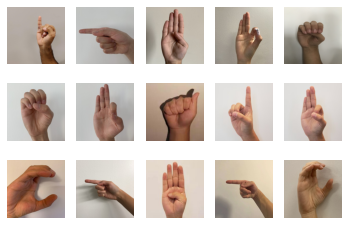

In [ ]:
# Visualize some sample data

import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part 2. Model Building and Sanity Checking

### Part (a) Convolutional Network

Building a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture letter. My model is a subclass of nn.Module.

**My CNN model has the following neural network architecture:**


* I used 3 Convolutional layers and 2 fully connected layers. 

- At the first Convolutional layer, the IN Channels are set to 3. This is beacuse I am are working with RGB color images. An RGB image contains 3 channels: red, green, and blue. 

- The out channels for Convolutional layers 1, 2, and 3 are 7, 12, and 15 respectively. I increased the number of out channels as the network gets deeper. This was done for the following reason: 

 - After each convolutional operation, a max pooling layer was applied. Pooling layers reduces the resultant image size while preserving the features in the resultant image. Since the size of the resultant images is now smaller, which results in the reduction of computation time, I can have additional out channels. The more out channel I have, I can capture more relevant patterns in the image.

 - The early layers typically learn simple patterns, such as veritcal, horizontal and/or diagonal lines. However, the deeper layers, typically learn more complex patters like faces or ASL hand sings in our case. We know that there will be more complex features in the deeper layers compared to the early layers and thus the reason why we should have more out channels in the deeper layers. 

- The kernal size for the convolution operation was set as a variable, so I can later try different kernal sizes and find the optimal kernal size for my dataset during hyper parameter tuning. The defualt value was set as 5. 

- After each convolution operation and applying the non-linear activation function (Relu), I applied a Max Pooling layer with the size of 2x2 with a stride of 2 (In total 3 max pooling layers). Max pooling layer was applied to reduce the computation time and enhance features. 


- Prior to feeding the data to the fully connected layer, the resultant from the last convolutional layer was flatten. The flatten size of the resultant is calculated by the formula in "self.input_fc".

- The first fully connected layer has 512 neurons. I selected this number to give the model greater classification ability. 

- The output of the second fully connected layer is 9. This is because we have 9 classes corresponding to 9 letters from A to I. 

- The non-linear activation functions selected was the Relu function which was applied after each convulotional operation but prior to applying the max pooling layer. I utilized Relu because Relu combats the vanishing gradient obstacle, which in return allows the neural netowrk to perform better. Relu is also the default activation function and very popular with developers, when making CNN models. 

In [ ]:
## CNN architectures

#Convolutional Neural Network Architecture
class HandGestureClassifier(nn.Module):
    def __init__(self,Kernal_Size=5):
        super(HandGestureClassifier, self).__init__()
        self.name = "HandGestureClassifier"
        self.conv1 = nn.Conv2d(3, 7, Kernal_Size)                 #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)                            #kernel_size, stride 
        self.conv2 = nn.Conv2d(7, 12, Kernal_Size)                #in_channels, out_chanels, kernel_size
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.conv3 = nn.Conv2d(12, 15, Kernal_Size)
        self.pool3 = nn.MaxPool2d(2, 2) 

        # Finding the input dimension for the First Fully connected layer 
        self.first_dim = np.floor((231/8)-((7/8)*Kernal_Size))       # Finding just the first dimension of the resultant from the last convolutional layer
        self.input_fc =  int(self.first_dim * self.first_dim * 15)   # 15 because we have 15 out channels in the last convolutional layer

        self.fc1 = nn.Linear(self.input_fc, 512)
        self.fc2 = nn.Linear(512, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, self.input_fc)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code

**For this project, I used the following loss function and optimizer:**

- Choice of loss function: CrossEntropyLoss
 - The purpose of the loss function is to compare the model's predicted values with the actual labels of the data to determine how well the neural network is perfoming. 
 - In this lab, we have to classify the hand gesture representing letters A-I of ASL. Therefore, we have multiple classes to classify (9 classes to be exact) and thus we need a loss function that can handle many classes. I selected CrossEntropyLoss for this purpose, since as mentioned in PyTorch official documnets, CrossEntropyLoss "is useful when training a classification problem with C classes". Therefore, if many classes need to be classified (multi-class classification problem), CrossEntropyLoss can be utilized. 

----------------------

 - Choice of Optimizer: SGD

   - To find the best optimizer, I compared the performance SGD (Stochastic Gradient Descent) optimizer and Adam optimizer. Although, Adam optimizer shows alot of promise with fast convergence (less training time) and requires less  parameters for tuning, it did not perform as well as SGD. SGD optimizer displayed better generalization performance for this dataset, thus I selected SGD optimizer along with incorporating momentum in the optimizer as the choice of Optimizer.

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
   
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate,epoch)
    return path

In [ ]:
def get_accuracy(model, data_loader):
  
  """ This function takes in a model and iterable dataset
      and returns the accuracy for the given dataset. 

      Args:
        model: The model that is used to train the dataset
               and proive predictions. 
        data_loader: Iterable dataset
      
      Returns:
        The accuracy for the given dataset
  """
  
  correct = 0
  total = 0
  for imgs, labels in data_loader:
      
      #------------To Enable GPU Usage-----------#
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #-----------------------------------------#
      
      output = model(imgs)
      
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

  return correct / total

In [ ]:
def train(model, train_loader, val_loader, batch_size=30, learning_rate=0.01, num_epochs=35):
    
    # Defining the loss function and optimizer 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []
    num_epoch, epoch_loss = [], []

    # Training The Nueral Network
    n_epoch = 0  # The number of Epochs
    n_iterations = 0 
    start_time = time.time()
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
            #------------To Enable GPU Usage-----------#
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #-----------------------------------------#
            optimizer.zero_grad()         # a clean up step for PyTorch  
            out = model(imgs)             # Forward Pass
            loss = criterion(out, labels) # computing the total loss
            loss.backward()               # Backward Pass (computing the parameter updates)         
            optimizer.step()              # making the updates for each parameter  

            losses.append(float(loss)) 
            
            n_iterations += 1 
            
        # Saving the Current Training Information
        epoch_loss.append(losses[-1])   
        train_acc.append(get_accuracy(model, train_loader))   # Computing Training Accuracy 
        val_acc.append(get_accuracy(model, val_loader))       # Computing Validation Accuracy
        

        # Printing the General information (# Epoch, Train and Validation Accuracy, Loss) for the current Epoch
        print(("Epoch {}: Iteration {}: Train Accuracy: {}, Validation Accuracy: {} |"+"losses: {}").format(
            epoch + 1, 
            n_iterations,
            train_acc[epoch],
            val_acc[epoch], 
            epoch_loss[-1]))
        
        # Saving the Current Model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        num_epoch.append(n_epoch)
        n_epoch += 1 

    print("")
    print('Model Training is Finished')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    print("")

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("")

    # Plotting the Loss Curve
    sns.set_theme()
    plt.figure(figsize=(10,6))
    plt.title("Training Curve")
    plt.plot(num_epoch, epoch_loss, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()
    
    # Plotting the Training & Validation Curves
    plt.figure(figsize=(10,6))
    plt.title("Training & Validation Curves")
    plt.plot(num_epoch, train_acc, label="Train")
    plt.plot(num_epoch, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training & Validation Accuracy")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

### Part (c) “Overfiting” to a Small Dataset 

One way to sanity check the neural network model and training code is to check whether the model is capable of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code should be able to memorize the answers to a small number of images quickly.

Using the small dataset collected earlier in this project, I will show that my model and training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, I should be able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
# defining the data directory
data_dir_Small = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Ahmadi_Hand_Gesture"

transform_small = transforms.Compose(
        [transforms.Resize([int(224), int(224)]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# loading and transforming the data using ImageFolder
data_small = datasets.ImageFolder(data_dir_Small, transform=transform_small)

In [ ]:
### getting the relevant indices for the train, validation, and test sets
  
indices_train_small = []
indices_Validation_small = []

for i in range(len(data_small)): 
  # Finding the image number of each image
  Pic_Number = (data_small.imgs[i][0]).split('/')[-1].split(".")[0].split("_")[-1]

  # images with the image number 1 and 2 will be allocated to the train dataset and images with the image number 3 will be allocated to the test set
  indices_train_small.append(i) if Pic_Number == "1" or Pic_Number == "2" else (indices_Validation_small.append(i))

In [ ]:
train_sampler_small = SubsetRandomSampler(indices_train_small)
train_loader_small = torch.utils.data.DataLoader(data_small, batch_size=20, sampler=train_sampler_small)

val_sampler_small = SubsetRandomSampler(indices_Validation_small)
val_loader_small = torch.utils.data.DataLoader(data_small, batch_size=20, sampler=val_sampler_small)

Epoch 1: Iteration 1: Train Accuracy: 0.1111111111111111, Validation Accuracy: 0.1111111111111111 |losses: 2.198079824447632
Epoch 2: Iteration 2: Train Accuracy: 0.1111111111111111, Validation Accuracy: 0.2222222222222222 |losses: 2.197377920150757
Epoch 3: Iteration 3: Train Accuracy: 0.1111111111111111, Validation Accuracy: 0.2222222222222222 |losses: 2.1960437297821045
Epoch 4: Iteration 4: Train Accuracy: 0.16666666666666666, Validation Accuracy: 0.2222222222222222 |losses: 2.194166660308838
Epoch 5: Iteration 5: Train Accuracy: 0.3333333333333333, Validation Accuracy: 0.2222222222222222 |losses: 2.1918225288391113
Epoch 6: Iteration 6: Train Accuracy: 0.4444444444444444, Validation Accuracy: 0.2222222222222222 |losses: 2.18898868560791
Epoch 7: Iteration 7: Train Accuracy: 0.4444444444444444, Validation Accuracy: 0.2222222222222222 |losses: 2.1856136322021484
Epoch 8: Iteration 8: Train Accuracy: 0.4444444444444444, Validation Accuracy: 0.2222222222222222 |losses: 2.1816353797912

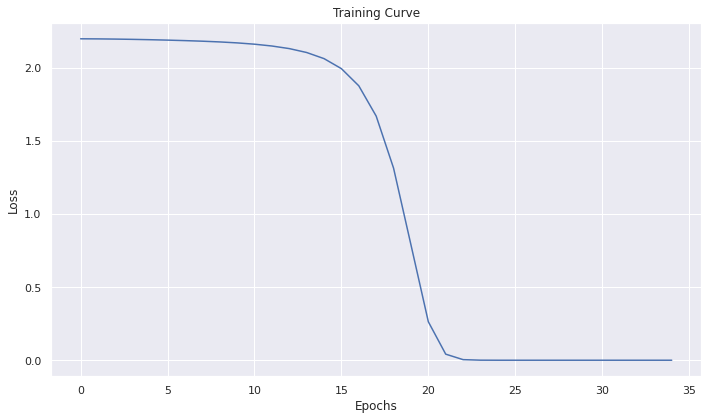

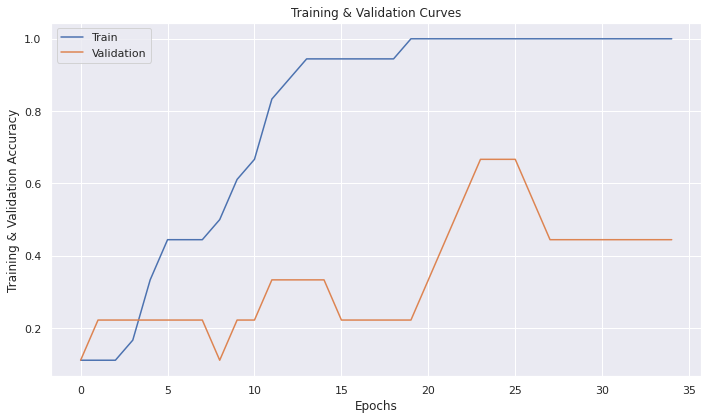

In [ ]:
use_cuda = True
model = HandGestureClassifier(Kernal_Size=5)
if torch.cuda.is_available():
    model.cuda()

train(model, train_loader_small, val_loader_small, batch_size=20, learning_rate=0.01, num_epochs=35)

### Part 3. Hyperparameter Search

### Part (a)

The following are the 3 hyperparameters I chose to tune my model with: 
 
 1. **Kernal Size** (hyperparameter related to the model architecture)

 2. **Learning Rate** 

 3. **Batch Size**

It should be noted that there are many more hyperparemeters for us to tune our model with, in order to obtain a better performing model, however, for the purposes of this project I have only selected 3 (mentioned above) hyperparemeters. 

- Kernal Size is the size of the kernal/filter in our convolutional layer. 

- Learning Rate controls the speed which the weights/parameters are updated w.r.t the loss function's gradient. The smaller the learning rate, the smaller steps we take along the loss curve to reach a local minima.

- Batch size is defined by the number of training samples propagated in 1 iteration before the weights of the model are updated. 




### Part (b)

Performing hyperparameter tuning on my model. 

Epoch 1: Iteration 14: Train Accuracy: 0.15462085308056872, Validation Accuracy: 0.16390041493775934 |losses: 2.194309949874878
Epoch 2: Iteration 28: Train Accuracy: 0.22571090047393366, Validation Accuracy: 0.21784232365145229 |losses: 2.187906503677368
Epoch 3: Iteration 42: Train Accuracy: 0.30213270142180093, Validation Accuracy: 0.3049792531120332 |losses: 2.101764440536499
Epoch 4: Iteration 56: Train Accuracy: 0.31575829383886256, Validation Accuracy: 0.3049792531120332 |losses: 2.0274462699890137
Epoch 5: Iteration 70: Train Accuracy: 0.3015402843601896, Validation Accuracy: 0.3049792531120332 |losses: 2.0394086837768555
Epoch 6: Iteration 84: Train Accuracy: 0.4259478672985782, Validation Accuracy: 0.45435684647302904 |losses: 1.7525172233581543
Epoch 7: Iteration 98: Train Accuracy: 0.5082938388625592, Validation Accuracy: 0.549792531120332 |losses: 0.8360714912414551
Epoch 8: Iteration 112: Train Accuracy: 0.6954976303317536, Validation Accuracy: 0.7199170124481328 |losses:

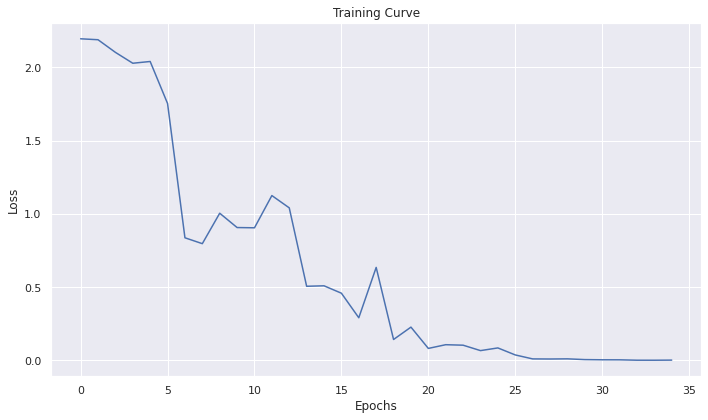

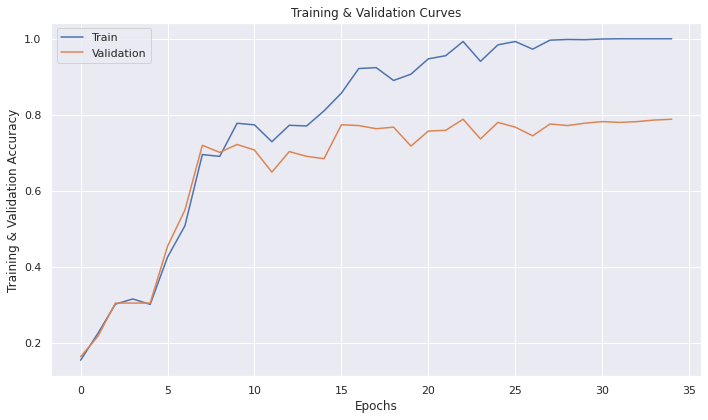

In [ ]:
### 1st Hyperparameter Setting ###

K_Size = 5    # Kernal Size
lr = 0.01     # Learning Rate
BS = 128      # Batch Size

use_cuda = True
model = HandGestureClassifier(Kernal_Size=5)
if torch.cuda.is_available():
    model.cuda()

train_loader = torch.utils.data.DataLoader(data, batch_size=BS, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=BS, sampler=val_sampler)


train(model, train_loader, val_loader, batch_size=BS, learning_rate=lr, num_epochs=35)

Epoch 1: Iteration 7: Train Accuracy: 0.11137440758293839, Validation Accuracy: 0.10995850622406639 |losses: 2.1963508129119873
Epoch 2: Iteration 14: Train Accuracy: 0.12322274881516587, Validation Accuracy: 0.11825726141078838 |losses: 2.196657180786133
Epoch 3: Iteration 21: Train Accuracy: 0.3122037914691943, Validation Accuracy: 0.3153526970954357 |losses: 2.1880264282226562
Epoch 4: Iteration 28: Train Accuracy: 0.3222748815165877, Validation Accuracy: 0.3257261410788382 |losses: 2.1698100566864014
Epoch 5: Iteration 35: Train Accuracy: 0.3299763033175355, Validation Accuracy: 0.2966804979253112 |losses: 2.0791170597076416
Epoch 6: Iteration 42: Train Accuracy: 0.5811611374407583, Validation Accuracy: 0.5767634854771784 |losses: 1.4437918663024902
Epoch 7: Iteration 49: Train Accuracy: 0.36492890995260663, Validation Accuracy: 0.3817427385892116 |losses: 1.970339298248291
Epoch 8: Iteration 56: Train Accuracy: 0.11374407582938388, Validation Accuracy: 0.11203319502074689 |losses:

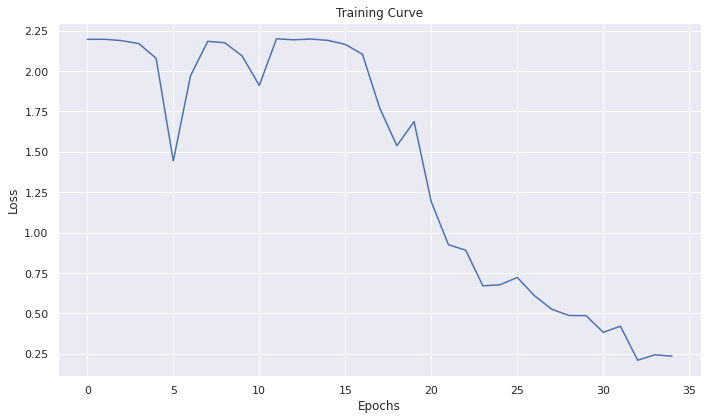

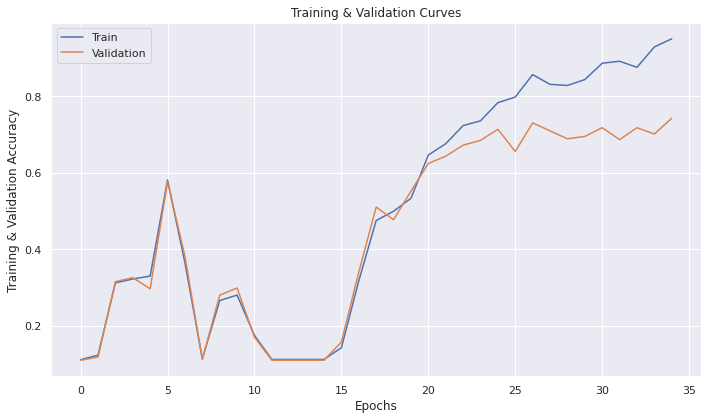

In [ ]:
### 2nd Hyperparameter Setting ###

K_Size = 6     # Kernal Size
lr = 0.01      # Learning Rate
BS = 256       # Batch Size

use_cuda = True
model = HandGestureClassifier(Kernal_Size=5)
if torch.cuda.is_available():
    model.cuda()

train_loader = torch.utils.data.DataLoader(data, batch_size=BS, num_workers=1, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=BS,num_workers=1, sampler=val_sampler)


train(model, train_loader, val_loader, batch_size=BS, learning_rate=lr, num_epochs=35)

Epoch 1: Iteration 27: Train Accuracy: 0.32049763033175355, Validation Accuracy: 0.3278008298755187 |losses: 2.191605806350708
Epoch 2: Iteration 54: Train Accuracy: 0.4277251184834123, Validation Accuracy: 0.45228215767634855 |losses: 2.624260663986206
Epoch 3: Iteration 81: Train Accuracy: 0.2559241706161137, Validation Accuracy: 0.26348547717842324 |losses: 2.172112464904785
Epoch 4: Iteration 108: Train Accuracy: 0.11196682464454977, Validation Accuracy: 0.11203319502074689 |losses: 2.229726552963257
Epoch 5: Iteration 135: Train Accuracy: 0.49644549763033174, Validation Accuracy: 0.44190871369294604 |losses: 1.7186150550842285
Epoch 6: Iteration 162: Train Accuracy: 0.5616113744075829, Validation Accuracy: 0.5456431535269709 |losses: 1.483637809753418
Epoch 7: Iteration 189: Train Accuracy: 0.6854265402843602, Validation Accuracy: 0.6618257261410788 |losses: 1.060597538948059
Epoch 8: Iteration 216: Train Accuracy: 0.7748815165876777, Validation Accuracy: 0.7282157676348547 |losse

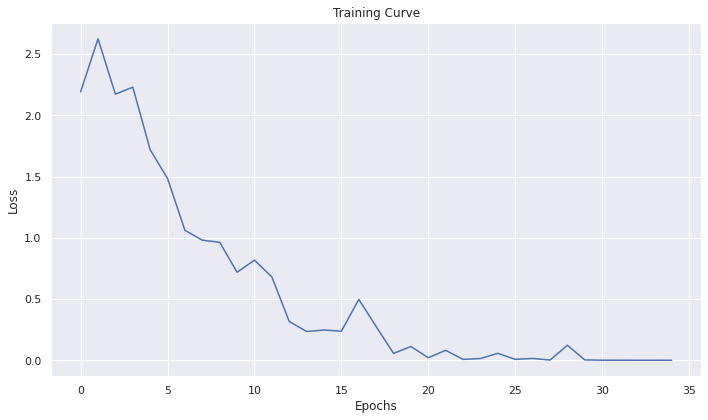

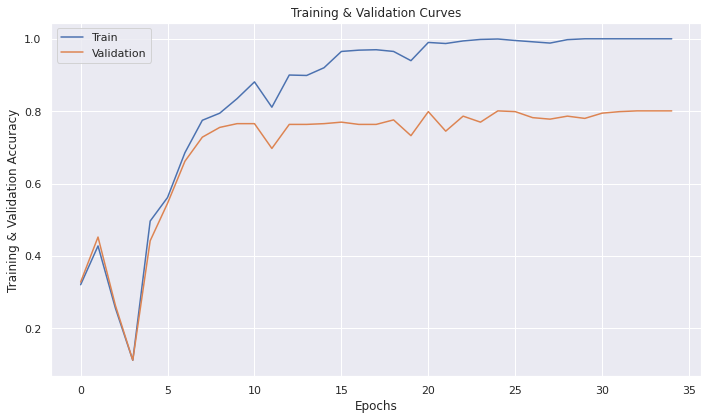

In [ ]:
### 3rd Hyperparameter Setting ###
###--------- BEST MODEL Hyperparameters ----------###

K_Size = 3   # Kernal Size
lr = 0.01    # Learning Rate
BS = 64      # Batch Size

use_cuda = True
model = HandGestureClassifier(Kernal_Size=5)
if torch.cuda.is_available():
    model.cuda()

train_loader = torch.utils.data.DataLoader(data, batch_size=BS, num_workers=1, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=BS,num_workers=1, sampler=val_sampler)


train(model, train_loader, val_loader, batch_size=BS, learning_rate=lr, num_epochs=35)

Epoch 1: Iteration 106: Train Accuracy: 0.5515402843601895, Validation Accuracy: 0.5705394190871369 |losses: 1.4491794109344482
Epoch 2: Iteration 212: Train Accuracy: 0.6421800947867299, Validation Accuracy: 0.6431535269709544 |losses: 1.3339214324951172
Epoch 3: Iteration 318: Train Accuracy: 0.7636255924170616, Validation Accuracy: 0.6742738589211619 |losses: 1.2156554460525513
Epoch 4: Iteration 424: Train Accuracy: 0.7742890995260664, Validation Accuracy: 0.6390041493775933 |losses: 1.5666520595550537
Epoch 5: Iteration 530: Train Accuracy: 0.8992890995260664, Validation Accuracy: 0.7551867219917012 |losses: 0.17524489760398865
Epoch 6: Iteration 636: Train Accuracy: 0.9300947867298578, Validation Accuracy: 0.7282157676348547 |losses: 0.4335809350013733
Epoch 7: Iteration 742: Train Accuracy: 0.9241706161137441, Validation Accuracy: 0.7385892116182573 |losses: 0.16109806299209595
Epoch 8: Iteration 848: Train Accuracy: 0.976303317535545, Validation Accuracy: 0.7759336099585062 |lo

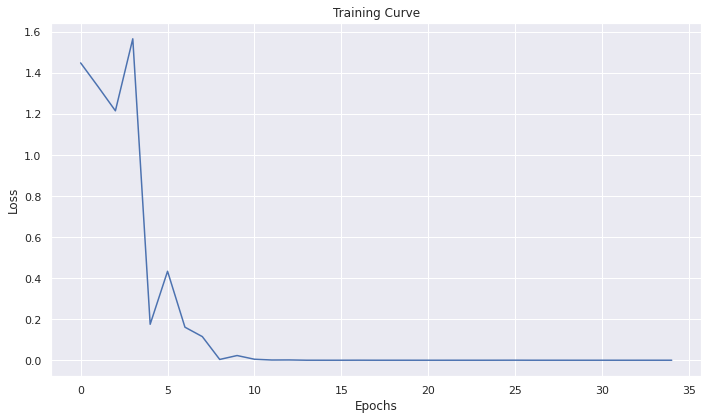

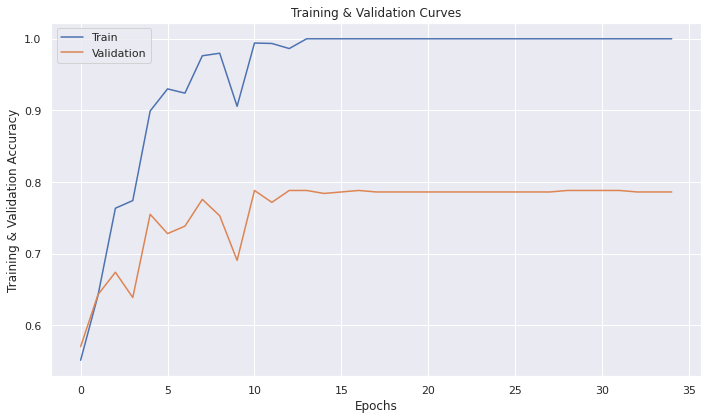

In [ ]:
### 4th Hyperparameter Setting ###

K_Size = 2   # Kernal Size
lr = 0.01    # Learning Rate
BS = 16      # Batch Size

use_cuda = True
model = HandGestureClassifier(Kernal_Size=5)
if torch.cuda.is_available():
    model.cuda()

train_loader = torch.utils.data.DataLoader(data, batch_size=BS, num_workers=1, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=BS,num_workers=1, sampler=val_sampler)


train(model, train_loader, val_loader, batch_size=BS, learning_rate=lr, num_epochs=35)

### Part (c)

 - The best model selected had the following hyperparameters (3rd Hyperparameter Setting): 

  *   Kernal Size: 3
  *   Learning Rate: 0.01 
  *   Batch Size: 64 

- This model was selected to be the best model since the model had the best performance on the validation data set. The model had the following train and validation accuracy: 

   *   Train Accuracy: 1.0
   *   Validation Accuracy: 0.801


- In addition, the validation of each epoch was closely examined, and the epoch that resulted in the best validation performance will be selected to find the test accuracy. 


### Part (d) 
Finding the test accuracy of my best model. 

In [ ]:
use_cuda = True
net = HandGestureClassifier()
if torch.cuda.is_available():
    model.cuda()

model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=34)
state = torch.load(model_path)
net.load_state_dict(state)

Test_Acc = get_accuracy(model, test_loader)
print("The test accuracy for the best model is:", Test_Acc)

The test accuracy for the best model is: 0.7471264367816092


### Part 4. Transfer Learning

For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a similar task to the one you need to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this project, I will use Transfer Learning to extract features from the hand gesture images. Then, train a smaller network to use these features as input and classify the hand gestures.

AlexNet architecture played a pivotal role in establishing Deep Neural Nets as a go-to tool for image classification problems and I will use an ImageNet pre-trained AlexNet model to extract features in this project.

### Part (a)
loading the AlexNet network, with pretrained weights. 

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Please note that:

* The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

* The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will output a tensor of shape Nx256x6x6 . (N = batch size).


In [ ]:
train_loader = torch.utils.data.DataLoader(data, batch_size=512, num_workers=1, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=512, num_workers=1, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(data, batch_size=512, num_workers=1, sampler=test_sampler)

In [ ]:
##-- AlexNet Features and Labels for the Training Data --##
dataiter = iter(train_loader)
images, labels = dataiter.next()

Alex_Train_Features = alexnet.features(images)
Alex_Train_Labels = labels

  # Saving the computed features as well as the labels
Alex_Train_Features_dir = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Alexnet/Train/Alex_Train_Features.pt"
torch.save(Alex_Train_Features, Alex_Train_Features_dir)

Alex_Train_Labels_dir = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Alexnet/Train/Alex_Train_Labels.pt"
torch.save(Alex_Train_Labels, Alex_Train_Labels_dir)

##-- AlexNet Features and Labels for the Validation Data --##
dataiter = iter(val_loader)
images, labels = dataiter.next()

Alex_Val_Features = alexnet.features(images)
Alex_Val_Labels = labels

  # Saving the computed features as well as the labels
Alex_Val_Features_dir = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Alexnet/Validation/Alex_Val_Features.pt"
torch.save(Alex_Val_Features, Alex_Val_Features_dir)

Alex_Val_Labels_dir = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Alexnet/Validation/Alex_Val_Labels.pt"
torch.save(Alex_Val_Labels, Alex_Val_Labels_dir)

##-- AlexNet Features and Labels for the Test Data --##
dataiter = iter(test_loader)
images, labels = dataiter.next()

Alex_Test_Features = alexnet.features(images)
Alex_Test_Labels = labels

  # Saving the computed features as well as the labels
Alex_Test_Features_dir = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Alexnet/Test/Alex_Test_Features.pt"
torch.save(Alex_Test_Features, Alex_Test_Features_dir)

Alex_Test_Labels_dir = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Alexnet/Test/Alex_Test_Labels.pt"
torch.save(Alex_Test_Labels, Alex_Test_Labels_dir)

In [ ]:
print("Shape of the AlexNet Feature for the Training Data:", Alex_Train_Features.size())
print("Shape of the AlexNet Feature for the Validation Data:",Alex_Val_Features.size())
print("Shape of the AlexNet Feature for the Test Data:",Alex_Test_Features.size())

Shape of the AlexNet Feature for the Training Data: torch.Size([512, 256, 6, 6])
Shape of the AlexNet Feature for the Validation Data: torch.Size([482, 256, 6, 6])
Shape of the AlexNet Feature for the Test Data: torch.Size([261, 256, 6, 6])


### Part (b)
Building a convolutional neural network model that takes as input these AlexNet features, and makes a prediction.

**Explaining my neural network architecture:** 

- The model I built is a subclass of nn.Module.
- The input to this model is the features pre-trained from AlexNet.

*   For my CNN architecture, I used 1 Convolutional layers and 2 fully connected layers. 

- I constructed only 1 Convolutional layers for this model becuase we are utilizing transfer learning from AlexNet. The features have be trained already using AlexNet and hence to avoid making the model more complex (the AlexNet model is already very complex and contains many layers), I just added 1 Convolutional layer to further reduce the image size and add to get more output channels. The objective of the added Convolutional layer is to complete additional future mappings/extractins.  

- At the first Convolutional layer, the In Channels are set to 256. This is beacuse the AlexNet features have 256 channels. 

- The Kernal size for the convultional layer is 2x2 with stride of 1.

- The out channels for Convolutional layers 1 is 512. 

- After the convolution operation and applying the non-linear activation function (Relu), I applied a Max Pooling layer with the size of 2x2 with a stride of 2 (1 Mx Pooling Layer). Pooling layers reduces the resultant image size while preserving the features in the resultant image. Max pooling layer was applied to reduce the computation time and enhance features. 

- Prior to feeding the data to the fully connected layer, the resultant from the last convolutional layer was flatten. 

- The first fully connected layer has 512 neurons. I selected this number to give the model greater classification ability. 

- The output of the second fully connected layer is 9. This is because we have 9 classes corresponding to 9 letters from A to I. 

- The non-linear activation functions selected was the Relu function which was applied after the convulotional operation but prior to applying the max pooling layer. I utilized Relu because Relu combats the vanishing gradient obstacle, which in return allows the neural netowrk to perform better. Relu is also the default activation function and very popular with developers, when making CNN models. 


It should be noted that several attempts were made to find the optimal model architecute. Different values for all the hyper-parameters were tried to find which model performes well. The final model architectures can be seen below.

In [ ]:
## CNN architectures

#Convolutional Neural Network Architecture
class AlexNet_CNN(nn.Module):
    def __init__(self):
        super(AlexNet_CNN, self).__init__()
        self.name = "AlexNet_CNN"

        self.conv1 = nn.Conv2d(256, 512, 2)
        self.pool = nn.MaxPool2d(2, 2)                            

        self.fc1 =  nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 2048)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (c) 
Training and tuning the new Convolutional Neural Network model

In [ ]:
# Loading the AlexNet Features and labels for the Training, Validation, and Test Data

Alex_Train_Features = torch.load(Alex_Train_Features_dir)
Alex_Train_Labels = torch.load(Alex_Train_Labels_dir)

Alex_Val_Features = torch.load(Alex_Val_Features_dir)
Alex_Val_Labels = torch.load(Alex_Val_Labels_dir)

Alex_Test_Features = torch.load(Alex_Test_Features_dir)
Alex_Test_Labels = torch.load(Alex_Test_Labels_dir)

In [ ]:
# self-check: Seeing if the dimension of the AlexNet Features for the Training, Validation, and Test Data are the same
print("Shape of the AlexNet Feature for the Training Data:", Alex_Train_Features.size())
print("Shape of the AlexNet Feature for the Validation Data:",Alex_Val_Features.size())
print("Shape of the AlexNet Feature for the Test Data:",Alex_Test_Features.size())

Shape of the AlexNet Feature for the Training Data: torch.Size([512, 256, 6, 6])
Shape of the AlexNet Feature for the Validation Data: torch.Size([482, 256, 6, 6])
Shape of the AlexNet Feature for the Test Data: torch.Size([261, 256, 6, 6])


In [ ]:
# Converting the AlexNet feature tensors into a numpy arrays, and then converting the numpy arrays back into a PyTorch tensors
Alex_Train_Features = torch.from_numpy(Alex_Train_Features.detach().numpy())
Alex_Val_Features = torch.from_numpy(Alex_Val_Features.detach().numpy())
Alex_Test_Features = torch.from_numpy(Alex_Test_Features.detach().numpy())

In [ ]:
# Merging the AlexNet Features and labels for the Training, Validation, and Test Data

Alex_Training_Data = []
for i in range(0, Alex_Train_Features.shape[0]):
   Alex_Training_Data.append([Alex_Train_Features[i], Alex_Train_Labels[i]])

Alex_Val_Data = []
for i in range(0, Alex_Val_Features.shape[0]):
   Alex_Val_Data.append([Alex_Val_Features[i], Alex_Val_Labels[i]])

Epoch 1: Iteration 32: Train Accuracy: 0.751953125, Validation Accuracy: 0.8132780082987552 |losses: 0.7676019072532654
Epoch 2: Iteration 64: Train Accuracy: 0.87109375, Validation Accuracy: 0.8443983402489627 |losses: 0.8975855112075806
Epoch 3: Iteration 96: Train Accuracy: 0.923828125, Validation Accuracy: 0.8506224066390041 |losses: 0.23941460251808167
Epoch 4: Iteration 128: Train Accuracy: 0.97265625, Validation Accuracy: 0.8879668049792531 |losses: 0.059793852269649506
Epoch 5: Iteration 160: Train Accuracy: 0.98046875, Validation Accuracy: 0.9190871369294605 |losses: 0.07406434416770935
Epoch 6: Iteration 192: Train Accuracy: 1.0, Validation Accuracy: 0.9294605809128631 |losses: 0.003089879872277379
Epoch 7: Iteration 224: Train Accuracy: 1.0, Validation Accuracy: 0.9356846473029046 |losses: 0.01276659406721592
Epoch 8: Iteration 256: Train Accuracy: 1.0, Validation Accuracy: 0.9336099585062241 |losses: 0.0016206733416765928
Epoch 9: Iteration 288: Train Accuracy: 1.0, Validat

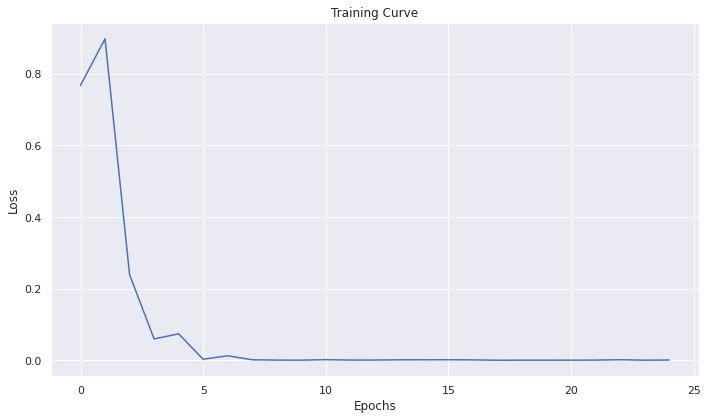

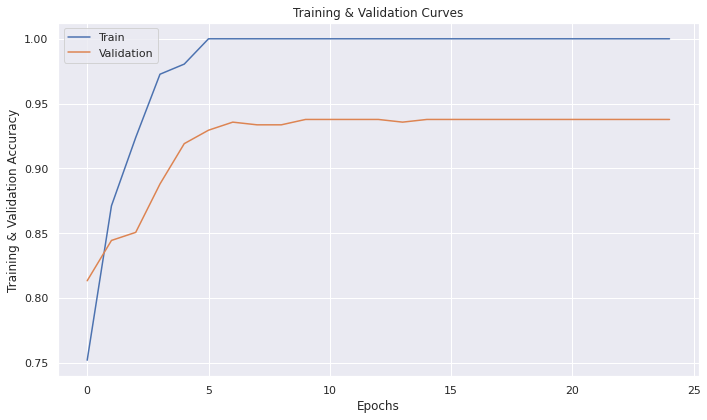

In [ ]:
# The Training and validation curves for the best model can be seen below
# Model Hyper-Parameters (Best Model)
BS = 16
lr = 0.01
Epoch = 25

train_loader = torch.utils.data.DataLoader(Alex_Training_Data, batch_size=BS, shuffle = True)
val_loader = torch.utils.data.DataLoader(Alex_Val_Data, batch_size=BS, shuffle = True)

use_cuda = True
model = AlexNet_CNN()
if torch.cuda.is_available():
    model.cuda()

train(model, train_loader, val_loader, batch_size=BS, learning_rate=lr, num_epochs=Epoch)

### Part (d)
Test accuracy of the best model.

In [ ]:
Alex_Test_Data = []
for i in range(0, Alex_Test_Features.shape[0]):
   Alex_Test_Data.append([Alex_Test_Features[i], Alex_Test_Labels[i]])

test_loader = torch.utils.data.DataLoader(Alex_Test_Data, batch_size=16, shuffle = True)

In [ ]:
use_cuda = True
if torch.cuda.is_available():
    model.cuda()

Test_accuracy = get_accuracy(model, test_loader)

print("The Test Accuracy for the best model using AlexNet features (transfer learning) is:", Test_accuracy)

The Test Accuracy for the best model using AlexNet features (transfer learning) is: 0.8850574712643678


Comparing the two approaches (approach 1: not using transfer learning; approach 2: using transfer learning)


 - The Test accuracy for the best model using AlexNet features (transfer learning) is 88.51%. 

 - The test accaccuracy for the best model without using transfer learning and using our own constructed CNN is 74.71%. 
 

We can see that the test accuracy has improved by approxiamtely 14%, which is big imporvment in the model performance.

This makes intuitive sense because, typically, people tend not to train entire CNN from scratch because people tend not to have access to large training data as well as the high computation time required to train a CNN. So instead, we use a pre-trained network (e.g., AlexNet). Alexnet is divided into 2 components, component 1 that computes "features" using convolutional layers and component 2 that classifies the founded features (these 2 componets can be utlizied separatly). AlexNet first component that computes features utilizing convolutional layers is a very deep and complex. AlexNet has been trained on over 1 million images and is able to classify images into 1000 object. From being trained on such a big dataset, the AlexNet model is able to find and extract significant features from any image dataset. This is why the model which used AlexNet features was able to outperform the model that we made without using transfer learning.

### Part 5. Testing on New Data 

As a final step in testing I will be revisiting the sample images that I had collected in part a of this project. These sample images are untouched and will be used to demonstrate how well my model works at identifying my hand guestures. 



In [ ]:
# loading the hand gesture images created by me

# defining the data directory
my_data_dir = "/content/drive/MyDrive/Colab Notebooks/Project_CNN/Data/Ahmadi_Hand_Gesture"
transform_myData = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# loading and transforming the data using ImageFolder
my_data = datasets.ImageFolder(my_data_dir, transform=transform_myData)

my_test_loader = torch.utils.data.DataLoader(my_data, batch_size=32)

In [ ]:
dataiter = iter(my_test_loader)
images, labels = dataiter.next()

Alex_myTest_Features = alexnet.features(images)
Alex_myTest_Labels = labels

In [ ]:
my_Test_Data = []
for i in range(0, Alex_myTest_Features.shape[0]):
   my_Test_Data.append([Alex_myTest_Features[i], Alex_myTest_Labels[i]])

my_test_loader = torch.utils.data.DataLoader(my_Test_Data, batch_size=32, shuffle = True)

In [ ]:
# Using the best transfer learning model developed in Part 4.

use_cuda = True
if torch.cuda.is_available():
    model.cuda()

my_data_test = get_accuracy(model, my_test_loader)
print("The test accuracy using the best transfer learning model on my sample images is:", my_data_test)

The test accuracy using the best transfer learning model on my sample images is: 0.9259259259259259


In [ ]:
# Printing the actual labels vs the predicted labels to see my model's performance on the different hand guestures
import pandas as pd

for imgs, labels in my_test_loader:
    
    #------------To Enable GPU Usage-----------#
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #-----------------------------------------#
    
    output = model(imgs)
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]

# Converting the labels to numpy array
label_np = (labels.view_as(pred)).cpu().data.numpy()
# Converting the predictions to numpy array
Pred_np = pred.cpu().data.numpy()

# Converting the predicted and labels to a dataframe for better visualizing the model's result
Actual_df = pd.DataFrame(label_np, columns = ["Actual Labels"])
Pred_df = pd.DataFrame(Pred_np, columns = ["Predicted Labels"] )

Combine_df = pd.concat([Actual_df, Pred_df], axis=1)
Combine_df

,Actual Labels,Predicted Labels
0,8,8
1,0,0
2,2,2
3,5,5
4,6,7
5,6,6
6,0,4
7,1,1
8,0,0
9,2,2


**Comparing the performance of the best transfer learning model on the two different datasets (1- my sample images founded in part A; 2- images from the "Hand_Gesture_Dataset")**
 
 - The test accuracy using the best transfer learning model on my sample images is: 92.6%

 - The test accuracy using the best transfer learning model on the "Hand_Gesture_Dataset" is 88.51%.

 - The test accuracy has improved when using the best transfer learning model on the sample images I have created. 

- Having a test accuracy of 92.6% and by examining the dataframe above, we can that the model was able to predict 25 images correctly and only miss classified two images. One image that the model miss classidied has an actual label of 6 which correponds to the F hand gensture. The other miss classidied image has an actual label of 0 which correponds to the A hand gensture. The 3 hand gestures for all the other letters were classified correctly. It is important to note that no model will ever be perfect and a couple of miss classifications are expected. 

- My model perfomed exceptionally becuase all the test data images were captured correctly. All images were 224 x 224, centered on the frame and there were no areas which the image were cut off. In addition, I practiced the ASL hand gestures to ensure all the signs I was making resembles the actual ASL hand sign. Essentially, the dataset contained only clean data with no noise and therefore it was easier for the model to make correct predictions, in contrast to, the "Hand_Gesture_Dataset" which contained some unclear images.

- In summary, my dataset was more clean than the test dataset that was extracted from the "Hand_Gesture_Dataset" and thats why my dataset yielded a better accuracy. 
